#Algorithms for Massive Dataset project: Finding similar items

The goal is to implement a **similar movie pair detector** from scratch. Each movie will be represented by aggregating information from various files in the dataset in a meaningful and non-trivial way.

The notebook is structured into the following sections:  

0. **Preliminary Steps** – Initial setup and data preparation.  
1. **Dataset Exploration** – Analyzing and understanding the dataset.  
2. **TF-IDF Measure** – Computing term frequency-inverse document frequency for feature representation.  
3. **The Inverted Index Structure** – Building an efficient indexing structure for token retrieval.  
4. **Cosine Distance** – Measuring similarity between movie representations.  
5. **Similarity Detection on the Movie Dataset** – Identifying and linking similar movie pairs.  
6. **Experiments and Evaluation** – Evaluating results and insights.


## 0. Preliminary Steps
In this project, **Python** 3.11 version is used along with the **Apache Spark API** 3.5.4 version, a framework designed for processing **Big Data** distributed across multiple clusters.  

### Sections Overview:  

- **Section 0.1:** **Importing** all necessary libraries required for data processing and analysis and defining the required paths for dataset storage access.
- **Section 0.2:** **Downloading** the dataset and preparing it for further processing.  

### 0.1. Environment Initialization


In [221]:
import pyspark
sc = pyspark.SparkContext('local[*]')

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[*]) created by __init__ at <ipython-input-1-9ae820830206>:2 

In [222]:
import sys
import os
from pyspark.sql import SparkSession

FULL_DATA_DIR = 'dataset/full_dataset/'
SMALL_DATA_DIR = 'dataset/small_dataset/'

# Change depending on the small or big dataset
#base_dir = os.path.join(FULL_DATA_DIR)
base_dir = os.path.join(SMALL_DATA_DIR)

###0.2. Dataset Download

In [223]:
# Dataset Download
!mkdir -p dataset
!mkdir -p dataset/full_dataset
!mkdir -p dataset/small_dataset

!kaggle datasets download -d gsimonx37/letterboxd --file actors.csv -p dataset/full_dataset
!kaggle datasets download -d gsimonx37/letterboxd --file countries.csv -p dataset/full_dataset
!kaggle datasets download -d gsimonx37/letterboxd --file crew.csv -p dataset/full_dataset
!kaggle datasets download -d gsimonx37/letterboxd --file genres.csv -p dataset/full_dataset
!kaggle datasets download -d gsimonx37/letterboxd --file languages.csv -p dataset/full_dataset
!kaggle datasets download -d gsimonx37/letterboxd --file movies.csv -p dataset/full_dataset
!kaggle datasets download -d gsimonx37/letterboxd --file posters.csv -p dataset/full_dataset
!kaggle datasets download -d gsimonx37/letterboxd --file releases.csv -p dataset/full_dataset
!kaggle datasets download -d gsimonx37/letterboxd --file studios.csv -p dataset/full_dataset
!kaggle datasets download -d gsimonx37/letterboxd --file themes.csv -p dataset/full_dataset

!unzip -o 'dataset/full_dataset/*.zip' -d dataset/full_dataset && rm dataset/full_dataset/*.zip

Dataset URL: https://www.kaggle.com/datasets/gsimonx37/letterboxd
License(s): GPL-3.0
 67% 51.0M/76.3M [00:00<00:00, 174MB/s]
100% 76.3M/76.3M [00:00<00:00, 185MB/s]
Dataset URL: https://www.kaggle.com/datasets/gsimonx37/letterboxd
License(s): GPL-3.0
  0% 0.00/2.39M [00:00<?, ?B/s]
100% 2.39M/2.39M [00:00<00:00, 155MB/s]
Dataset URL: https://www.kaggle.com/datasets/gsimonx37/letterboxd
License(s): GPL-3.0
 60% 28.0M/46.5M [00:00<00:00, 150MB/s]
100% 46.5M/46.5M [00:00<00:00, 169MB/s]
Dataset URL: https://www.kaggle.com/datasets/gsimonx37/letterboxd
License(s): GPL-3.0
  0% 0.00/3.04M [00:00<?, ?B/s]
100% 3.04M/3.04M [00:00<00:00, 133MB/s]
Dataset URL: https://www.kaggle.com/datasets/gsimonx37/letterboxd
License(s): GPL-3.0
  0% 0.00/3.67M [00:00<?, ?B/s]
100% 3.67M/3.67M [00:00<00:00, 83.1MB/s]
Dataset URL: https://www.kaggle.com/datasets/gsimonx37/letterboxd
License(s): GPL-3.0
 83% 88.0M/106M [00:00<00:00, 178MB/s]
100% 106M/106M [00:00<00:00, 157MB/s] 
Dataset URL: https://www.kagg

## 1. Dataset Exploration  

The dataset consists of **10 CSV files** containing information about films. Below are the files along with their respective attributes:  

- **actors.csv**: Id, Name, Role  
- **countries.csv**: Id, Country  
- **crew.csv**: Id, Role, Name  
- **genres.csv**: Id, Genre  
- **languages.csv**: Id, Type, Language  
- **movies.csv**: Id, Name, Date, Tagline, Description, Minute, Rating  
- **posters.csv**: Id, Link  
- **releases.csv**: Id, Country, Date, Type, Rating  
- **studios.csv**: Id, Studio  
- **themes.csv**: Id, Theme  

### Sections Overview:  

- **Section 1.1:** The dataset is **subsampled** to reduce the computational cost of the algorithms, creating a smaller dataset.  
- **Section 1.2:** The datasets are **organized** into two directories:  
  - `dataset/small_dataset` (subsampled)  
  - `dataset/full_dataset` (original)  
- **Section 1.3:** The dataset is **loaded** into the distributed filesystem while ensuring the validity of each data entry.  
- **Section 1.4:** The dataset is **encoded** using the **Bag of Words** approach, where the **Id** serves as the key, and the value is a list of tokens.

###1.1. Dataset Sampling

To create the subsampled dataset, the `sample` function is used. The process begins with **movies.csv**, where only **1% of the records** are selected. The corresponding **movie IDs** from this sample are then extracted and used to **filter** all other files, ensuring that only records related to the selected movies are retained.

In [224]:
from pyspark.sql.functions import col

# Initialize Spark session
spark = SparkSession.builder.appName("SubsampleDataset").getOrCreate()

# Load datasets
movies = spark.read.csv(FULL_DATA_DIR+"movies.csv", header=True, inferSchema=True)
actors = spark.read.csv(FULL_DATA_DIR+"actors.csv", header=True, inferSchema=True)
countries = spark.read.csv(FULL_DATA_DIR+"countries.csv", header=True, inferSchema=True)
crew = spark.read.csv(FULL_DATA_DIR+"crew.csv", header=True, inferSchema=True)
genres = spark.read.csv(FULL_DATA_DIR+"genres.csv", header=True, inferSchema=True)
languages = spark.read.csv(FULL_DATA_DIR+"languages.csv", header=True, inferSchema=True)
posters = spark.read.csv(FULL_DATA_DIR+"posters.csv", header=True, inferSchema=True)
releases = spark.read.csv(FULL_DATA_DIR+"releases.csv", header=True, inferSchema=True)
studios = spark.read.csv(FULL_DATA_DIR+"studios.csv", header=True, inferSchema=True)
themes = spark.read.csv(FULL_DATA_DIR+"themes.csv", header=True, inferSchema=True)

# Step 1: Sample movies
sampled_movies = movies.sample(withReplacement=False, fraction=0.01, seed=42)
sampled_ids = sampled_movies.select("Id").distinct()

# Step 2: Filter related datasets
sampled_actors = actors.join(sampled_ids, "Id", "inner")
sampled_countries = countries.join(sampled_ids, "Id", "inner")
sampled_crew = crew.join(sampled_ids, "Id", "inner")
sampled_genres = genres.join(sampled_ids, "Id", "inner")
sampled_languages = languages.join(sampled_ids, "Id", "inner")
sampled_posters = posters.join(sampled_ids, "Id", "inner")
sampled_releases = releases.join(sampled_ids, "Id", "inner")
sampled_studios = studios.join(sampled_ids, "Id", "inner")
sampled_themes = themes.join(sampled_ids, "Id", "inner")

# Step 3: Save the subsampled datasets into a single CSV file
sampled_movies.coalesce(1).write.csv(SMALL_DATA_DIR+"temp/movies.csv", header=True, mode="overwrite")
sampled_actors.coalesce(1).write.csv(SMALL_DATA_DIR+"temp/actors.csv", header=True, mode="overwrite")
sampled_countries.coalesce(1).write.csv(SMALL_DATA_DIR+"temp/countries.csv", header=True, mode="overwrite")
sampled_crew.coalesce(1).write.csv(SMALL_DATA_DIR+"temp/crew.csv", header=True, mode="overwrite")
sampled_genres.coalesce(1).write.csv(SMALL_DATA_DIR+"temp/genres.csv", header=True, mode="overwrite")
sampled_languages.coalesce(1).write.csv(SMALL_DATA_DIR+"temp/languages.csv", header=True, mode="overwrite")
sampled_posters.coalesce(1).write.csv(SMALL_DATA_DIR+"temp/posters.csv", header=True, mode="overwrite")
sampled_releases.coalesce(1).write.csv(SMALL_DATA_DIR+"temp/releases.csv", header=True, mode="overwrite")
sampled_studios.coalesce(1).write.csv(SMALL_DATA_DIR+"temp/studios.csv", header=True, mode="overwrite")
sampled_themes.coalesce(1).write.csv(SMALL_DATA_DIR+"temp/themes.csv", header=True, mode="overwrite")

print("Subsampling completed.")

Subsampling completed.


###1.2. Folder organization

In [225]:
dir_names = []
file_names = []
root_dir = 'dataset/small_dataset/temp/'

for root, dirs, files in os.walk(root_dir):
    # root: current directory path
    # dirs: list of subdirectories in the current directory
    # files: list of files in the current directory

    # Iterate over each subdirectory in the current directory
    for d in dirs:
        dir_names.append(d);
    for f in files:
        if f.endswith('.csv'):
            file_names.append(f)

dirs_and_files = zip(dir_names, file_names)

for d, f in dirs_and_files:
    os.rename(root_dir+d+"/"+f, SMALL_DATA_DIR+d)

!rm -rf dataset/small_dataset/temp

print("Folder organization completed")

Folder organization completed


### 1.3. Dataset Preprocessing

In this section, all **CSV files** are loaded into the **distributed dataset**.  

Each record in the **RDD** is represented as a **key-value pair**, where the **key** is the **movie ID**, and the **value** is a **string** containing the remaining attributes of the record.  

Each file is loaded individually using the `load_data` function, which calls the `parse_data` function. `parse_data` applies the `parse_datafile_line` function to each entry in the file which ensures data validity by:

- Verifying that each entry follows the correct pattern (MovieId is mandatory, while other attributes are optional),
- Removing quotation marks using the `remove_quotes` function,
- Retaining only valid records in the **RDD**.

In [226]:
import re
DATAFILE_PATTERN = r'^([^,]+)(?:,(.*))?$'

In [227]:
def remove_quotes(s):
    """ Remove quotation marks from an input string

    Args:
        s (str): input string that might have the quote "" characters

    Returns:
        str: a string without the quote characters
    """
    return ''.join(i for i in s if i!='"')


def parse_datafile_line(datafile_line):
    """ Parse a line of the data file using the specified regular expression
    pattern

    Args:
        datafileLine (str): input string that is a line from the data file

    Returns:
        str: a string parsed using the given regular expression and without
             the quote characters
    """

    match = re.search(DATAFILE_PATTERN, datafile_line.decode('utf-8'))
    if match is None:
        print('Invalid datafile line: {}'.format(datafile_line))
        return (datafile_line, -1)
    elif match.group(1) == 'id':
        print('Header datafile line: {}'.format(datafile_line))
        return (datafile_line, 0)
    else:
        product = ' '.join([remove_quotes(group) for group in match.groups()[1:] if group])
        #product = '%s' % (match.group(2))
        return ((remove_quotes(match.group(1)), product), 1)


def parse_data(filename):
    """ Parse a data file

    Args:
        filename (str): input file name of the data file

    Returns:
        RDD: a RDD of parsed lines
    """
    return (sc
            .textFile(filename, 4, 0)
            .map(parse_datafile_line)
            )


def load_data(path):
    """ Load a data file

    Args:
        path (str): input file name of the data file

    Returns:
        RDD: a RDD of parsed valid lines
    """

    filename = os.path.join(base_dir, path)
    raw = parse_data(filename).cache()
    #print('Loading {} in the Distributed Dataset'.format(path))

    failed = (raw
              .filter(lambda s: s[1] == -1)
              .map(lambda s: s[0]))

    for line in failed.take(10):
        #print('{} - Invalid datafile line: {}'.format(path, line))
        print(line)

    valid = (raw
             .filter(lambda s: s[1] == 1)
             .map(lambda s: s[0])
             .cache())
    """
    print('{} - Read {} lines, successfully parsed {} lines, '
           'failed to parse {} lines'.format(path,
                                             raw.count(),
                                             valid.count(),
                                             failed.count()))
    """
    assert failed.count() == 0
    assert raw.count() == (valid.count() + 1)
    return valid

###1.4. Bag of Words

After the initial preprocessing, the documents are represented using the **Bag of Words** model. This model encodes each document as a set of words—or more precisely, tokens—appearing in it, without considering word order or grammar.  

This transformation is performed using the `tokenize` function, which takes a **key-value pair** as input and outputs a **key-token list pair**, where:  
- The **key** remains the movie ID.  
- The **value** is converted into a **list of tokens** extracted from the original text.

Inside the string to be converted, there may be stop words, which are words that frequently appear in written texts of a given language and do not carry significant informational content. For this reason, the `tokenize` function detects and removes them.

In [228]:
#stopfile = os.path.join(STOPWORDS_PATH)
#stopwords = set(sc.textFile(stopfile).collect())
stopwords = {'a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and', 'any', 'are', 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'did', 'do', 'does', 'doing', 'don', 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'it', 'its', 'itself', 'just', 'me', 'more', 'most', 'my', 'myself', 'no', 'nor', 'not', 'now', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 's', 'same', 'she', 'should', 'so', 'some', 'such', 't', 'than', 'that', 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up', 'very', 'was', 'we', 'were', 'what', 'when', 'where', 'which', 'while', 'who', 'whom', 'why', 'will', 'with', 'you', 'your', 'yours', 'yourself', 'yourselves'}

split_regex = r'\W+'

def tokenize(string):
    """ An implementation of input string tokenization that excludes stopwords

    Args:
        string (str): input string

    Returns:
        list: a list of tokens without stopwords
    """
    return [s for s in re.split(split_regex, string.lower())
            if s != '' and not s in stopwords]

## 2. The Inverted Index structure

An **inverted index** is a data structure commonly used to efficiently search and retrieve documents that contain a specific token (or word). It maps tokens (terms) to the list of documents or records that contain them, rather than mapping documents to the tokens they contain.

### Structure of an Inverted Index:

1. **Tokens (Terms):** The unique words (or tokens) found in a collection of documents.
2. **Document IDs (or references):** These are identifiers that refer to the documents that contain the token.

The idea behind an inverted index is that instead of scanning through every document to find a token, for each token is stored a list of documents in which it appears. With this structure it is easy to quickly retrieve documents that contain a specific token without having to look through every document individually.

### Sections Overview:  
- **Section 2.1: The Invert function**  

- **Section 2.2: The Swap function**  







###2.1. The Invert function

To create inverted indices, the first step is to implement a function called `invert`. This function, given a pair `(MovieId, token list)`, returns a list of pairs `(token, MovieId)`.

The `invert` function can then be used to convert entire datasets into their corresponding inverted indices.

In [229]:
def invert(record):
    """ Invert (MovieId, token vector) to a list of (token, MovieId)

    Args:
        record: a pair, (MovieId, token vector)

    Returns:
        pairs: a list of pairs of token to MovieId
    """

    pairs = [(f, record[0]) for f in record[1]]
    return pairs


###2.2. The Swap function

The `swap` function swaps the positions of the token and its associated information in a given record. This function, given a pair `(token, (MovieId1, movieId2))`, returns a pair `((MovieId1, MovieId2), token)`.
Basically, it reverses their positions so that the movie pair becomes the key, and the token becomes the value.

In [230]:
def swap(record):
    """ Swap (token, (MovieId1, MovieId2)) to ((MovieId1, MovieId2), token)

    Args:
        record: a pair, (token, (MovieId1, MovieId2))

    Returns:
        pair: ((MovieId1, MovieId2), token)
    """
    token = record[0]
    keys = record[1]
    return (keys, token)


##3. TF.IDF Measure
To improve the technique based on the bag of words, it is important to assign different weights to the tokens in a document to reflect the relevance of specific terms. An effective heuristic to identify these terms is the TF.IDF (Term Frequency times Inverse Document Frequency) measure, obtained by multiplying two indicators defined below.

### Sections Overview:  
- **Section 3.1: Term Frequency**  
The Term Frequency gives higher weight to tokens that tend to occur multiple times within the same document. It is calculated as the relative frequency of the token in the document.
If \\(t\\) is the number of occurrencies of a token in \\(d\\) which is the number of total occurrencies, the Term Frequency of \\(t\\) in \\(d\\) is \\(\mathrm{TF}(t, d) = \frac{t}{d}\\).

- **Section 3.2: Inverse Document Frequency**  
The Inverse Document Frequency assigns higher weight to tokens that rarely occur across the dataset. The formula is:
\\(\mathrm{IDF}(t) = \frac{N}{n(t)}\\), where \\(N\\) &egrave; is the total number of documents and \\(n(t)\\) is the number of documents that contains \\(t\\).

- **Section 3.3: TF.IDF**  
The TF.IDF measure of a token \(t\) in a document \(d\) is the product of Term Frequency and Inverse Document Frequency.
A high TF.IDF indicates a token that frequently appears in a specific document but rarely in others, and thus, more weight will be assigned, in computing the similarity between two documents, to the fact that both contain a term with a high TF.IDF value.



###3.1. Term Frequency
The function `tf`, given a list of tokens, returns a dictionary mapping each token to its corresponding Term Frequency.
The function works as follows:
- Create an empty dictionary;
- For each token in the list passed as an argument, add it as a key with a value of 1 if it is not already in the dictionary; otherwise, increment the associated value by one;
- For each token in the dictionary, divide the associated value by the total number of tokens in the list passed as arguments

In [231]:
def tf(tokens):
    """ Compute TF

    Args:
        tokens (list of str): input list of tokens from tokenize

    Returns:
        dictionary: a dictionary of tokens to its TF values
    """
    val = {}
    for t in tokens:
        if t in val:
            val[t] += 1
        else:
            val[t] = 1.0
    for t in val:
        val[t] /= len(tokens)
    return val

###3.2. Inverse Document Frequency
The function `idfs` assigns the Inverse Document Frequency (IDF) value to each token appearing in a corpus of documents, returning an RDD of pairs (𝑡, 𝑖), where 𝑡 and 𝑖 are, respectively, a token and its corresponding IDF value.

The function will execute the following steps:
- Calculate 𝑁, the total number of documents in the corpus;
- Create an RDD that, for each document in the corpus, contains all the unique tokens it includes;
- For each unique token 𝑡, count how many times it appears in the corpus to compute 𝑛(𝑡) and subsequently the Inverse Document Frequency for
𝑡.


In [232]:
def idfs(corpus):
    """ Compute IDF

    Args:
        corpus (RDD): input corpus

    Returns:
        RDD: a RDD of (record ID, IDF value)
    """

    N = corpus.count() * 1.0
    unique_tokens = corpus.map(lambda s: list(set(s[1])))
    token_count_pair_tuple = unique_tokens.flatMap(lambda t: [(s, 1) for s in t]) # (token, 1)
    token_sum_pair_tuple = token_count_pair_tuple.reduceByKey(lambda a, b: a+b)   # (token, count(token))
    return token_sum_pair_tuple.map(lambda s: (s[0], N/s[1]))   # (token, idfs(token))


###3.3. TF.IDF
The function `tfidf`, given a list of tokens in a document and the dictionary returned by idfs, returns a dictionary mapping the tokens in the list to their corresponding TF.IDF values.

The function will:
- Calculate the TF for all tokens in the list;
- Create a dictionary where each token (the key) is mapped to its TF value multiplied by its corresponding IDF value

In [233]:
def tfidf(tokens, idfs):
    """ Compute TF-IDF

    Args:
        tokens (list of str): input list of tokens from tokenize
        idfs (dictionary): record to IDF value

    Returns:
        dictionary: a dictionary of records to TF-IDF values
    """
    tfs = tf(tokens)
    tf_idf_dict = {t: tfs[t]*idfs[t] for t in tokens}
    return tf_idf_dict

##4. Cosine Distance

The measure of similarity between documents used in this project is the **cosine distance**, which interprets two objects as directions in a space and calculates the cosine of the angle formed by these directions.

The documents are encoded as directions in space, and therefore as vectors. Each possible token in our corpus represents a dimension: a generic document will have as the component in the dimension corresponding to a token the corresponding value of the TF.IDF measure.
The following sections implement this similarity measurement.

##Sections Overview

- **Section 4.1: Dot product and Norm**  
In this section the dot product \\( a \cdot b \\) and the norm \\( \| a \| \|  b \|   \\) are computed.

- **Section 4.2: Cosine Similarity**  
In this section the angle between two vectors is computed. This can be done easily by recalling that \\( a \cdot b = \| a \| \| b \| \cos \theta \\), where \\( a \cdot b \\) denotes the dot product of two vectors \\(a\\) and \\(b\\), \\(\theta\\) is the angle between these vectors, and \\(\| a \|\\) denotes the norm of \\(a\\). Therefore:

$$ \mathrm{sim}(a, b) = \cos \theta = \frac{a \cdot b}{\|a\| \|b\|} = \frac{\sum a_i b_i}{\sqrt{\sum a_i^2} \sqrt{\sum b_i^2}} .$$

- **Section 4.3: Fast Cosine Similarity**
In this section a more efficient algorithm for computing the cosine similarity is presented.
This function operates on pre-tokenized and preprocessed data, avoiding repetitive computations and uses broadcast variables.  



###4.1. Dot Product and Norm
- The function `dotprod` takes as arguments the dictionaries representing two sparse vectors and returns their corresponding dot product (in this case, equal to the sum of the products of the values corresponding to keys that appear in both dictionaries). In this case the keys of the dictionary are the tokens and the values are their TF.IDF values.

- The function `norm` returns the norm of a sparse vector passed as a dictionary (calculating it as the square root of the dot product of the vector with itself).

In [234]:
import math

def dotprod(a, b):
    """ Compute dot product

    Args:
        a (dictionary): first dictionary of record to value
        b (dictionary): second dictionary of record to value

    Returns:
        dotProd: result of the dot product with the two input dictionaries
    """

    return sum([a[t] * b[t] for t in a if t in b])


def norm(a):
    """ Compute square root of the dot product

    Args:
        a (dictionary): a dictionary of record to value

    Returns:
        norm: a dictionary of tokens to its TF values
    """
    return math.sqrt(dotprod(a, a))


###4.2. Cosine Similarity
The function `cossim` returns the cosine similarity between the two sparse vectors specified as arguments, using the formula provided above and the functions defined in the previous points.

The function `cosine_similarity`, given two strings representing documents and a dictionary of IDF values for a corpus, computes and returns the cosine similarity between the corresponding vectors in the token space. The necessary steps are:
- Tokenize the two strings and then use them along with the dictionary to call the tf.idf function
- Call the cossim function passing the dictionary with the tokens and their TF.IDF value and then return the similarity between them.

In [235]:
def cossim(a, b):
    """ Compute cosine similarity

    Args:
        a (dictionary): first dictionary of record to value
        b (dictionary): second dictionary of record to value

    Returns:
        cossim: dot product of two dictionaries divided by the norm of the first dictionary and
                then by the norm of the second dictionary
    """
    return dotprod(a, b)/(norm(a) * norm(b))


def cosine_similarity(string1, string2, idfs_dictionary):
    """ Compute cosine similarity between two strings

    Args:
        string1 (str): first string
        string2 (str): second string
        idfsDictionary (dictionary): a dictionary of IDF values

    Returns:
        cossim: cosine similarity value
    """

    w1 = tfidf(tokenize(string1), idfs_dictionary)
    w2 = tfidf(tokenize(string2), idfs_dictionary)
    return cossim(w1, w2)


###4.3. Fast Cosine Similarity
The function `fast_cosine_similarity`
takes as input a record in the format `((MovieId1, MovieId2), tokens list)` and:
- Computes the corresponding dot product.
- The result is then divided by the norm of the vectors describing the two documents involved.

The function returns a pair where the key is `(MovieId1, MovieId2)` and the value is the computed similarity score.
This function is more efficient than the last one because the tf-idf weights and the norm are precomputed and stored in two broadcast variables. This reduces communication costs between nodes and improves the performance because each worker has local access to the data.

In [236]:
def fast_cosine_similarity(record, tfidf_combined_broadcast, norm_combined_broadcast):
    """Compute Cosine Similarity between two movies using Broadcast variables.

    Args:
        record: ((movie1_id, movie2_id), common_tokens)
        joined_data_weights_broadcast: Broadcast variable containing TF-IDF weights.
        joined_data_norm_broadcast: Broadcast variable containing precomputed norms.

    Returns:
        pair: ((movie1_id, movie2_id), cosine similarity value)
    """

    movie1_id, movie2_id = record[0]  # Extract movie IDs
    common_tokens = record[1]         # Extract common tokens

    # Compute dot product using TF-IDF weights from the broadcast variable
    dot_product = sum(
        tfidf_combined_broadcast.value[movie1_id].get(t, 0) *
        tfidf_combined_broadcast.value[movie2_id].get(t, 0)
        for t in common_tokens
    )

    # Get precomputed norms from the broadcast variable
    norm1 = norm_combined_broadcast.value.get(movie1_id, 0)
    norm2 = norm_combined_broadcast.value.get(movie2_id, 0)

    # Compute the cosine similarity
    cosine_similarity = dot_product / (norm1 * norm2)

    return ((movie1_id, movie2_id), cosine_similarity)


## **5. Similarity Detection on the Movie Dataset**  

Entity resolution (ER) is the process of identifying and linking records within a dataset (or across multiple datasets) that refer to the same real-world entity, such as a person, product, or location.  

In this project, the goal is to identify pairs of similar movies by leveraging the functions defined in the previous sections.

The key steps in the similarity detection process are outlined below:

#### 1. **Dataset Preparation**
- ##### 1.1. **Load the CSV files**  
 Load the CSV files (like actors.csv, genres.csv, etc.) into the distributed system. The format of each record is the following: `('MovieId', 'Attributes')` and they are saved in a Resilient Distributed Dataset (RDD).
- ##### 1.2. **Convert the data format**  
 Convert each data entry from `('MovieId', 'Attributes')` format to `('MovieId', [token list])` format. This involves processing the relevant fields (e.g., title, description, genres, etc.) to create a tokenized list for each movie.
- ##### 1.3. **Create a Combined Dataset**
   Combine the relevant RDD (e.g., movies, genres, actors..) into a single RDD. This resulting dataset will facilitate efficient processing and comparison of movie records.  
   The data format is the same: `('MovieId', [token list])`

#### 2. **Compute the TF-IDF values**
- ##### 2.1. **Compute Inverse Document Frequency (IDF) Values**
   - Calculate the Inverse Document Frequency (IDF) values for the entire Combined Dataset. The IDF is used to weigh terms based on their frequency across documents, helping to highlight important (less common) words.
   - Store the computed IDF values as a broadcast variable. Broadcast variables in Spark are sent to the workers only once and stored locally for quick access, optimizing the computation process.
   - The data format is: `{'token1': idfsToken1, 'token2':idfsToken2, ...} `.

- ##### 2.2. **Apply TF-IDF Transformation**
   - Use the previously computed IDF values to perform a Term Frequency-Inverse Document Frequency (TF-IDF) transformation. This process generates an RDD that maps each `MovieId` to a dictionary of tokens, where each token is associated with its corresponding TF-IDF measure. The TF-IDF measure helps to evaluate the importance of each token in relation to the Combined Dataset.
   - The data format is: `[('MovieId1', {'token1':idfsToken1, 'token2':idfsToken2, ...}), ..., ('MovieId2', {'token1':idfsToken1, 'token2':idfsToken2, ...})]`  

#### 3. **Create the final structure for Movie Comparisons**
 - ##### 3.1. **Invert the TF-IDF weights**
    - Create an inverted index structure, which maps each token to the list of movie IDs containing that token. This index allows for fast retrieval of movies that share common tokens.
    - The RDD computed at point 2.2. is inverted and saved in the new inverted RDD. The value of the TF-IDF are not considered.  
    - The data format is: `[('token1', 'MovieId1'), ('token2', 'MovieId1'), ..., ('tokenN', 'MovieIdN')]`
 - ##### 3.2. **Identify Common Tokens Between Combined Dataset Records**
    -  Create a new RDD that includes only tokens shared between movies. Each element in this RDD is a pair where the key is a token, and the value is a (MovieId1, MovieId2) pair.
    - Swap the elements in each pair, so that the key becomes the (MovieId1, MovieId2) pair, and the value is the common token.
 - ##### 3.3. **Avoid Record with the Same Key**
    - Filter and remove the records that have the same film ids: eg. ('1010', '1010')
    - Sort the same key with switched movieIds: eg. ('1111', '0000') = ('0000', '1111') and remove the duplicates with distinct().
    - groupByKey the elements in the dataset and the final RDD every record maps each (MovieId1, MovieId2) to a list of common tokens.
    - The data format is: `(('MovieId1', 'MovieId2'), [token list])`


#### 4. **Compute the Cosine Similarity using precomputed TF-IDF and Norms**
 - ##### 4.1. **Compute Vector Norms**
   - Generate an additional RDD that maps each `MovieId` to the norm of its corresponding TF-IDF vector.
   - Convert this RDD into dictionaries and store them as broadcast variables allowing fast access to the norms during similarity calculations.
   - The data format is: `[('MovieId1', normMovieId1), ('MovieId2', normMovideId2), ...]`

 - ##### 4.2. **Compute the Fast Cosine Similarity**
    -  The Fast Cosine Similarity is computed for each record (pair of movies) in the Common Tokens Dataset based on their common tokens.  
    - This function is more efficient because the tf-idf weights and the norm are stored in two broadcast variables. This reduces communication costs between nodes and improves the performance because each worker has local access to the data.
    - The result is an RDD that contains the cosine similarity scores.   
    The data format is: `(('MovieId1', 'MovieId2'), Cosine Similarity)`

The following is a sample code that shows step-by-step the procedure explained.

In [237]:
# 1.1 - Load the .csv files in the Distributed File System in the following format: ('MovieId', 'Attributes')
actors = load_data('actors.csv')
countries = load_data('countries.csv')
crew = load_data('crew.csv')
genres = load_data('genres.csv')
languages = load_data('languages.csv')
movies = load_data('movies.csv')
posters = load_data('posters.csv')
releases = load_data('releases.csv')
studios = load_data('studios.csv')
themes = load_data('themes.csv')

# 1.2 - Converting data from ('MovieId', 'Attributes') to ('MovieId', [token list]) format
tokenized_actors = actors.map(lambda s: (s[0], tokenize(s[1]))).reduceByKey(lambda a, b: a + b)
tokenized_countries = countries.map(lambda s: (s[0], tokenize(s[1]))).reduceByKey(lambda a, b: a + b)
tokenized_crew = crew.map(lambda s: (s[0], tokenize(s[1]))).reduceByKey(lambda a, b: a + b)
tokenized_genres = genres.map(lambda s: (s[0], tokenize(s[1]))).reduceByKey(lambda a, b: a + b)
tokenized_languages = languages.map(lambda s: (s[0], tokenize(s[1]))).reduceByKey(lambda a, b: a + b)
tokenized_movies = movies.map(lambda s: (s[0], tokenize(s[1]))).reduceByKey(lambda a, b: a + b)
tokenized_posters = posters.map(lambda s: (s[0], tokenize(s[1]))).reduceByKey(lambda a, b: a + b)
tokenized_releases = releases.map(lambda s: (s[0], tokenize(s[1]))).reduceByKey(lambda a, b: a + b)
tokenized_studios = studios.map(lambda s: (s[0], tokenize(s[1]))).reduceByKey(lambda a, b: a + b)
tokenized_themes = themes.map(lambda s: (s[0], tokenize(s[1]))).reduceByKey(lambda a, b: a + b)

# 1.3 - Joining the data in a Combined Dataset used to compute similarity
combined_dataset = tokenized_movies.leftOuterJoin(tokenized_genres)
combined_dataset = combined_dataset.map(lambda x: (x[0], x[1][0] + (x[1][1] if x[1][1] is not None else []))) #OK

# 2.1 - Create a corpus of document and compute the idfs
union_dataset = tokenized_movies.union(tokenized_genres)
idfs_union = idfs(union_dataset)
idfs_union_weights = idfs_union.collectAsMap()
idfs_union_broadcast = sc.broadcast(idfs_union_weights)

# 2.2 - Assign the tf.idf weight to each token in the Combined Dataset
tfidf_combined_dataset = combined_dataset.map(lambda s: (s[0], tfidf(s[1], idfs_union_broadcast.value)))
tfidf_combined_broadcast = sc.broadcast(tfidf_combined_dataset.collectAsMap())

# 3.1 - Invert the TF-IDF weights
combined_dataset_inv = (tfidf_combined_dataset.flatMap(lambda r: invert(r)).cache())

# 3.2 - Identifying Common Tokens between Movie Records
common_tokens = (combined_dataset_inv
                .join(combined_dataset_inv)
                .map(lambda r: swap(r)))

# 3.3 - Avoid record with the same key and also key with same moviIds but inverted
common_tokens = (common_tokens
                .filter(lambda r: r[0][0] != r[0][1])         # Ensure keys are different
                .map(lambda r: (tuple(sorted(r[0])), r[1]))   # Sort the key to normalize
                .distinct()                                   # Remove possible duplicates
                .groupByKey()
                .mapValues(list)
                .cache())

# 4.1 - Compute the norm of each record of the Combined Dataset
norm_combined_dataset = tfidf_combined_dataset.map(lambda s: (s[0], norm(s[1])))
norm_combined_broadcast = sc.broadcast(norm_combined_dataset.collectAsMap())

# 4.2 - Compute the fast cosine similarity between the records of the Combined Dataset
similarities_combined_dataset = (common_tokens
                    .map(lambda r: fast_cosine_similarity(r, tfidf_combined_broadcast, norm_combined_broadcast ))
                    .cache())

##6. Experiments and Evaluation
In the previous section a general method to detect similarities between movies has been presented.  
In this section the goal is to aggregate in different ways the informations contained in the various files in the dataset and compute their similarities.


##Sections Overview
- **Section 6.1: Revisited Helper Functions**  
In this section the functions for the dataset preprocessing are modified to be adapted to the tests.

- **Section 6.2. Test1: similarity based on Movie Name, Theme and Genre**  
- **Section 6.3. Test2: similarity based on Movie Name, Actors Name and Studio**


###6.1. Revisited Helper Functions
These functions differ slightly from the previous ones. In this case, `load_data` takes a CSV file and the corresponding `data_pattern` as input, and loads the data into an RDD in the following format:  
`[('MovieId1', 'attribute1', 'attribute2', ..., 'attributeN'), ('MovieId2', 'attribute1', 'attribute2', ..., 'attributeN'), ...]`.  
In this way it is possible to filter out an entire columns of a specific attribute if not needed.
Additionally, the `data_pattern` has changed. Now, each dataset has its own specific pattern, and while the `MovieId` remains mandatory, other fields may also be required depending on the dataset.



In [238]:
import re
ACTORS_PATTERN = '^(.+),(.+),(.+)'
COUNTRIES_PATTERN = '^(.+),(.+)'
CREW_PATTERN = '^(.+),(.*),(.+)'
GENRES_PATTERN = '^(.+),(.+)'
LANGUAGES_PATTERN = '^(.+),(.*),(.+)'
MOVIES_PATTERN = '^([^,]+),([^,]+),([^,]*),([^,]*),\"([^\"]+)\",([^,]*),([^,]*)$'
POSTERS_PATTERN = '^(.+),(.+)'
RELEASES_PATTERN = '^(.+),(.+),(.+),(.+),(.+)'
STUDIOS_PATTERN = '^(.+),(.+)'
THEMES_PATTERN = '^(.+),(.+)'


def parse_datafile_line_list(datafile_line, datafile_pattern):
    """ Parse a line of the data file using the specified regular expression
    pattern

    Args:
        datafileLine (str): input string that is a line from the data file

    Returns:
        str: a string parsed using the given regular expression and without
             the quote characters
    """

    match = re.search(datafile_pattern, datafile_line.decode('utf-8'))
    if match is None:
        #print('Invalid datafile line: {}'.format(datafile_line))
        return (datafile_line, -1)
    elif match.group(1) == 'id':
        #print('Header datafile line: {}'.format(datafile_line))
        return (datafile_line, 0)
    else:
        product = [remove_quotes(group) for group in match.groups()[1:]]
        return ((remove_quotes(match.group(1)), *product), 1)

def parse_data_list(filename, datafile_pattern):
    """ Parse a data file

    Args:
        filename (str): input file name of the data file

    Returns:
        RDD: a RDD of parsed lines
    """
    return (sc
            .textFile(filename, 4, 0)
            .map(lambda line: parse_datafile_line_list(line, datafile_pattern))
            )

def load_data_list(path, datafile_pattern):
    """ Load a data file

    Args:
        path (str): input file name of the data file

    Returns:
        RDD: a RDD of parsed valid lines
    """

    filename = os.path.join(base_dir, path)
    raw = parse_data_list(filename, datafile_pattern).cache()
    #print('Loading {} in the Distributed Dataset'.format(path))

    failed = (raw
              .filter(lambda s: s[1] == -1)
              .map(lambda s: s[0]))
    """
    for line in failed.take(10):
        #print('{} - Invalid datafile line: {}'.format(path, line))
        print(line)
    """
    valid = (raw
             .filter(lambda s: s[1] == 1)
             .map(lambda s: s[0])
             .cache())
    """
    print('{} - Read {} lines, successfully parsed {} lines, '
           'failed to parse {} lines'.format(path,
                                             raw.count(),
                                             valid.count(),
                                             failed.count()))
    """
    return valid


###6.2. Test1: similarity based on Movie Name, Theme, Genre
In this section, the similarity between movies is done comparing: Movie Names, Themes and Genres.

In [279]:
# Load the .csv files in the Distributed File System in the following format: ('MovieId', 'Attributes')
movies = load_data_list('movies.csv', MOVIES_PATTERN)
themes = load_data_list('themes.csv', THEMES_PATTERN)
genres = load_data_list('genres.csv', GENRES_PATTERN)

# Filter the attributes
movies = movies.map(lambda s: (s[0], s[1]))    # Selecting the ('id', 'description')
themes = themes.map(lambda s: (s[0], s[1]))    # Selecting the ('id', 'theme')
genres = genres.map(lambda s: (s[0], s[1]))    # Selecting the ('id', 'genre')

# Converting data from ('MovieId', 'Attributes') to ('MovieId', [token list]) format
tokenized_movies = movies.map(lambda s: (s[0], tokenize(s[1]))).reduceByKey(lambda a, b: a + b)
tokenized_themes = themes.map(lambda s: (s[0], tokenize(s[1]))).reduceByKey(lambda a, b: a + b)
tokenized_genres = genres.map(lambda s: (s[0], tokenize(s[1]))).reduceByKey(lambda a, b: a + b)

# Joining the data in a Combined Dataset used to compute similarity
combined_dataset = tokenized_movies.join(tokenized_themes).map(lambda x: (x[0], x[1][0] + x[1][1]))
combined_dataset = combined_dataset.join(tokenized_genres).map(lambda x: (x[0], x[1][0] + x[1][1]))

# Create a corpus of document and compute the idfs
union_dataset = tokenized_movies.union(tokenized_themes).union(tokenized_genres)
idfs_union = idfs(union_dataset)
idfs_union_weights = idfs_union.collectAsMap()
idfs_union_broadcast = sc.broadcast(idfs_union_weights)

# Assign the tf.idf weight to each token in the Combined Dataset
tfidf_combined_dataset = combined_dataset.map(lambda s: (s[0], tfidf(s[1], idfs_union_broadcast.value)))
tfidf_combined_broadcast = sc.broadcast(tfidf_combined_dataset.collectAsMap())

# Invert the TF-IDF weights
combined_dataset_inv = (tfidf_combined_dataset.flatMap(lambda r: invert(r)).cache())

# Identifying Common Tokens between Movie Records
common_tokens = (combined_dataset_inv
                .join(combined_dataset_inv)
                .map(lambda r: swap(r)))

# Avoid record with the same key and also key with same moviIds but inverted
common_tokens = (common_tokens
                .filter(lambda r: r[0][0] != r[0][1])         # Ensure keys are different
                .map(lambda r: (tuple(sorted(r[0])), r[1]))   # Sort the key to normalize
                .distinct()                                   # Remove possible duplicates
                .groupByKey()
                .mapValues(list)
                .cache())

# Compute the norm of each record of the Combined Dataset
norm_combined_dataset = tfidf_combined_dataset.map(lambda s: (s[0], norm(s[1])))
norm_combined_broadcast = sc.broadcast(norm_combined_dataset.collectAsMap())

# Compute the fast cosine similarity between the records of the Combined Dataset
similarities_combined_dataset = (common_tokens
                    .map(lambda r: fast_cosine_similarity(r, tfidf_combined_broadcast, norm_combined_broadcast))
                    .cache())

# Calculate the average of the cosine similarity values
similarity_values = similarities_combined_dataset.map(lambda x: x[1])  # Extract similarity values
average_similarity = similarity_values.mean()  # Calculate the average

# Print the result
print("Average Cosine Similarity:", average_similarity)

Average Cosine Similarity: 0.008925972561834293


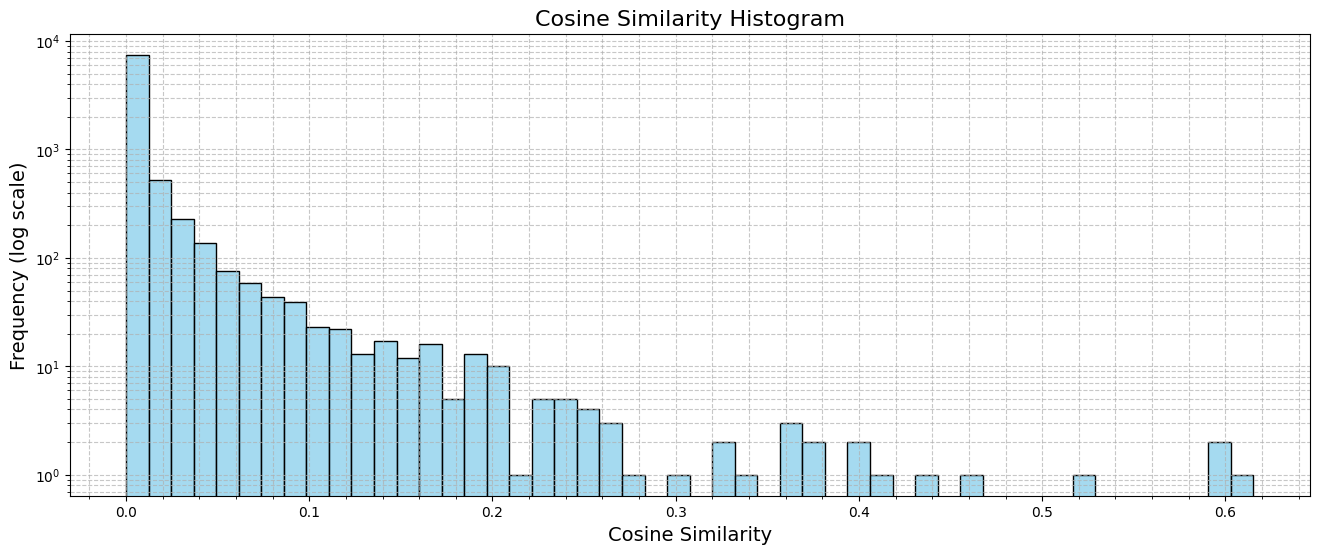

In [280]:
import matplotlib.pyplot as plt
import seaborn as sns

# Collect the cosine similarity values
similarity_values = similarities_combined_dataset.map(lambda x: x[1]).collect()

# Plot the histogram
plt.figure(figsize=(16, 6))
sns.histplot(similarity_values, kde=False, bins=50, color='skyblue', edgecolor='black')

# Logarithmic scale on the y-axis
plt.yscale("log")

# Add labels and title
plt.title('Cosine Similarity Histogram', fontsize=16)
plt.xlabel('Cosine Similarity', fontsize=14)
plt.ylabel('Frequency (log scale)', fontsize=14)

# Add dense grid for both major and minor ticks
plt.grid(True, which="both", linestyle="--", alpha=0.7)
plt.minorticks_on()

plt.show()

This histogram represents the distribution of cosine similarity scores between movies, based on their name, actor names, and studio. The x-axis shows the cosine similarity values, while the y-axis (log scale) represents the frequency of pairs with a given similarity.
In the histogram:

- The majority of cosine similarity values are close to zero. This indicates that most movie pairs in the dataset have very little similarity if movies' name and movies' theme are compared.
- There is a rapid drop in frequency as similarity increases, meaning that highly similar movie pairs are rare. This is expected in large datasets with wide range of attributes where only a small fraction of movies share strong similarities in names, themes, and genres.
- There are very few cases where the cosine similarity exceeds 0.5, reinforcing the idea that most movies do not have highly overlapping feature representations.  

The pairs of movies that have a similarity higher then 0.5 are filtered out, sorted in descending order and then their common tokens are checked to see if the similarities computed make sense.



In [281]:
# Filter the dataset to get similarities greater than or equal to 0.5
similarity_subset = similarities_combined_dataset.filter(lambda x: x[1] >= 0.5).sortBy(lambda x: x[1], ascending=False)
similarity_dict = dict(similarity_subset.collect())

# Collect the keys
similarity_keys = similarity_dict.keys()
distinct_keys = set([key for pair in similarity_keys for key in pair])

# Extract the Movie Name
movies_subset = movies.filter(lambda x: x[0] in distinct_keys)
movies_dict = dict(movies_subset.collect())

# Extract the Common Tokens
common_tokens_subset = common_tokens.filter(lambda x: x[0] in similarity_keys)
common_tokens_dict = dict(common_tokens_subset.collect())

In [282]:
for (key1, key2), tokens in common_tokens_dict.items():
    movie1 = movies_dict.get(str(key1), 'Unknown Movie')
    movie2 = movies_dict.get(str(key2), 'Unknown Movie')
    similarity = similarity_dict.get((key1, key2), 'Unknown Similarity')

    # Print the information for each pair of movies and their common tokens
    print(f"Movies: {movie1} ({key1}) & {movie2} ({key2})")
    print(f"Similarity: {similarity}")
    print(f"Common Tokens: {', '.join(tokens)}\n")

Movies: Until the End of the World (1005301) & In This World (1029601)
Similarity: 0.6152028818200194
Common Tokens: beyond, earth, drama, humanity, odyssey, world

Movies: Across the Universe (1002378) & The Jazz Singer (1028500)
Similarity: 0.5212564504592899
Common Tokens: catchy, tunes, artists, stardom, renowned, life, drama, rhythms, musicians, emotional, romance, legendary, dance, song

Movies: Wicked City (1006008) & Hate Crime (1041655)
Similarity: 0.5931524490496227
Common Tokens: revenge, challenging, sexual, brutal, graphic, violence, horror, themes, twists

Movies: The To Do List (1003353) & The F**k-It List (1010851)
Similarity: 0.5998007328395565
Common Tokens: coming, underdogs, list, antics, school, age, comedy, teen, laughter



Based on these results, the similarity between movies primarily depends on their themes rather than their titles.

It is also evident that the pair "Until the End of the World" & "In This World"  has a higher similarity score despite having fewer common tokens than "Across the Universe" & "The Jazz Singer". This occurs because the TF-IDF algorithm assigns different weights to different words.

The similarity analysis reveals that:
- The first pair of movies belong to the drama genre; however, their plots differs from each other and the shared words identified by the algorithm have distinct meanings in the context of each film.
- The second pair consists of drama, musical, and sentimental films. While their plots are not directly similar, the algorithm effectively detects their common genres.
- The third pair consists of horror and action films. The plots and the contexts of the films are different.
- The fourth pair includes comedy films that share common tokens in their titles and themes. Additionally, some aspects of their plots are similar.
  
In the end, in this example, the genre is a strong indicator and also the theme plays a major role in determining similarity, grouping movies with common narrative and context.


### 6.3. Test2: similarity based on Movie name, Actor Name and Studio
In this section, the similarity between movies is done comparing: Movie Name, Actor Name and Studio.

In [364]:
# Load the .csv files in the Distributed File System in the following format: ('MovieId', 'Attributes')
actors = load_data_list('actors.csv', ACTORS_PATTERN)
movies = load_data_list('movies.csv', MOVIES_PATTERN)
studios = load_data_list('studios.csv', STUDIOS_PATTERN)

# Filter the attributes
actors = actors.map(lambda s: (s[0], s[1]))          # Selecting the ('id', 'name')
movies = movies.map(lambda s: (s[0], s[1]))          # Selecting the ('id', 'name')
studios = studios.map(lambda s: (s[0], s[1]))        # Selecting the ('id', 'description')


# Converting data from ('MovieId', 'Attributes') to ('MovieId', [token list]) format
tokenized_actors = actors.map(lambda s: (s[0], tokenize(s[1]))).reduceByKey(lambda a, b: a + b)
tokenized_movie = movies.map(lambda s: (s[0], tokenize(s[1]))).reduceByKey(lambda a, b: a + b)
tokenized_studios = studios.map(lambda s: (s[0], tokenize(s[1]))).reduceByKey(lambda a, b: a + b)

# Joining the data in a Combined Dataset used to compute similarity
combined_dataset = tokenized_actors.join(tokenized_movie).map(lambda x: (x[0], x[1][0] + x[1][1]))
combined_dataset = combined_dataset.join(tokenized_studios).map(lambda x: (x[0], x[1][0] + x[1][1]))

# Create a corpus of document and compute the idfs
union_dataset = tokenized_actors.union(tokenized_movie).union(tokenized_studios)
idfs_union = idfs(union_dataset)
idfs_union_weights = idfs_union.collectAsMap()
idfs_union_broadcast = sc.broadcast(idfs_union_weights)

#  Assign the tf.idf weight to each token in the Combined Dataset
tfidf_combined_dataset = combined_dataset.map(lambda s: (s[0], tfidf(s[1], idfs_union_broadcast.value)))
tfidf_combined_broadcast = sc.broadcast(tfidf_combined_dataset.collectAsMap())

# Invert the TF-IDF weights
combined_dataset_inv = (tfidf_combined_dataset.flatMap(lambda r: invert(r)).cache())

# Identifying Common Tokens between Movie Records
common_tokens = (combined_dataset_inv
                .join(combined_dataset_inv)
                .map(lambda r: swap(r)))

# Avoid record with the same key and also key with same moviIds but inverted
common_tokens = (common_tokens
                .filter(lambda r: r[0][0] != r[0][1])         # Ensure keys are different
                .map(lambda r: (tuple(sorted(r[0])), r[1]))   # Sort the key to normalize
                .distinct()                                   # Remove possible duplicates
                .groupByKey()
                .mapValues(list)
                .cache())

# Compute the norm of each record of the Combined Dataset
norm_combined_dataset = tfidf_combined_dataset.map(lambda s: (s[0], norm(s[1])))
norm_combined_broadcast = sc.broadcast(norm_combined_dataset.collectAsMap())

# Compute the fast cosine similarity between the records of the Combined Dataset
similarities_combined_dataset = (common_tokens
                    .map(lambda r: fast_cosine_similarity(r, tfidf_combined_broadcast, norm_combined_broadcast ))
                    .cache())

# Calculate the average of the cosine similarity values
similarity_values = similarities_combined_dataset.map(lambda x: x[1])  # Extract similarity values
average_similarity = similarity_values.mean()  # Calculate the average

# Print the result
print("Average Cosine Similarity:", average_similarity)


Average Cosine Similarity: 0.00038059428990501763


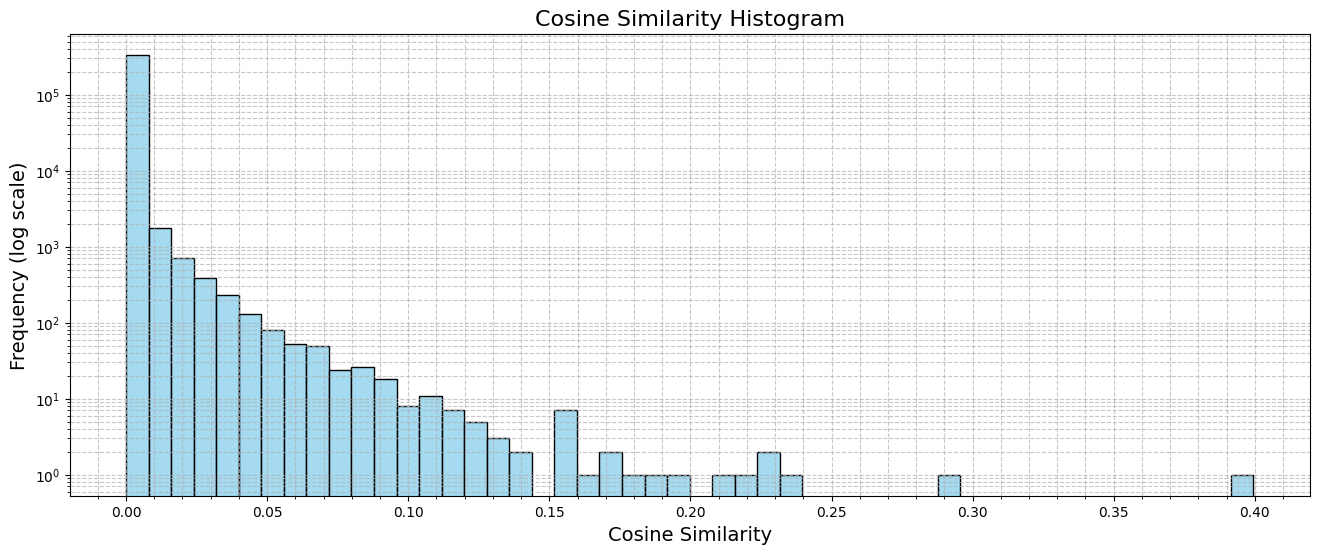

In [365]:
import matplotlib.pyplot as plt
import seaborn as sns

# Collect the cosine similarity values
similarity_values = similarities_combined_dataset.map(lambda x: x[1]).collect()

# Plot the histogram
plt.figure(figsize=(16, 6))
sns.histplot(similarity_values, kde=False, bins=50, color='skyblue', edgecolor='black')

# Logarithmic scale on the y-axis
plt.yscale("log")

# Add labels and title
plt.title('Cosine Similarity Histogram', fontsize=16)
plt.xlabel('Cosine Similarity', fontsize=14)
plt.ylabel('Frequency (log scale)', fontsize=14)

# Add dense grid for both major and minor ticks
plt.grid(True, which="both", linestyle="--", alpha=0.7)
plt.minorticks_on()

plt.show()

This histogram represents the distribution of cosine similarity scores between movies, based on their name, actor names, and studio. The x-axis shows the cosine similarity values, while the y-axis (log scale) represents the frequency of pairs with a given similarity.
In the histogram:

- The majority of movie pairs have a similarity close to zero, meaning they share few or no common features.
As similarity increases, the frequency of pairs decreases, suggesting that highly similar movies (in terms of movie name, actors role and studio) are much less common.
- A few peaks at higher similarity values indicate that some movies share significant attributes, possibly sequels, remakes, or films from the same studio.

The pairs of movies that have a similarity higher then 0.2 are filtered out, sorted in descending order and then their common tokens are checked to see if the similarities computed make sense.


In [368]:
# Filter the dataset to get similarities greater than or equal to 0.2
similarity_subset = similarities_combined_dataset.filter(lambda x: x[1] >= 0.20).sortBy(lambda x: x[1], ascending=False)
similarity_dict = dict(similarity_subset.collect())

# Collect the keys
similarity_keys = similarity_dict.keys()
distinct_keys = set([key for pair in similarity_keys for key in pair])

# Extract the Movie Name
movies_subset = movies.filter(lambda x: x[0] in distinct_keys)
movies_dict = dict(movies_subset.collect())

# Extract the Common Tokens
common_tokens_subset = common_tokens.filter(lambda x: x[0] in similarity_keys)
common_tokens_dict = dict(common_tokens_subset.collect())

In [369]:
for (key1, key2), tokens in common_tokens_dict.items():
    movie1 = movies_dict.get(str(key1), 'Unknown Movie')
    movie2 = movies_dict.get(str(key2), 'Unknown Movie')
    similarity = similarity_dict.get((key1, key2), 'Unknown Similarity')

    # Print the information for each pair of movies and their common tokens
    print(f"Movies: {movie1} ({key1}) & {movie2} ({key2})")
    print(f"Similarity: {similarity}")
    print(f"Common Tokens: {', '.join(tokens)}\n")

Movies: Chris Rock: One Man Show (1417275) & Baddiel & Skinner's Fantasy Football (1563779)
Similarity: 0.39945100701404146
Common Tokens: entertain

Movies: Country Christmas Album (1118316) & Blasko (1419247)
Similarity: 0.22400697418883242
Common Tokens: barefoot

Movies: My Wife Is A Gangster 2 (1079802) & Bar Legend (1184398)
Similarity: 0.21589009340679577
Common Tokens: jo, mi, park, ryung, kim, hyun

Movies: The Fortune Teller (1168549) & Ko-Ko's Conquest (1250563)
Similarity: 0.28794276636743477
Common Tokens: fleischer, inkwell

Movies: The New York Hat (1040518) & Back to the Kitchen (1582246)
Similarity: 0.22599484478691073
Common Tokens: gish

Movies: Heritage Minutes: Terry Fox (1410234) & Heritage Minutes: Tommy Prince (1445279)
Similarity: 0.23713003764452245
Common Tokens: heritage, historica, canada, minutes

Movies: Dragon Ball Z: Broly - Second Coming (1013939) & Dragon Ball Z: Bio-Broly (1014860)
Similarity: 0.215453396716631
Common Tokens: yoshiyuki, company, bird

The similarity analysis reveals that
- Most of the pairs show high similarities because they are produced by the same animation studios like: Chris Rock: One Man Show & (Baddiel & Skinner's Fantasy Football), Country Christmas Album & Blasko.
-  The pair Heritage Minutes: Terry Fox & Heritage Minutes: Tommy Prince share the same production house and similar movie name because they are part of the same series of movie.
- The Dragon Ball Z: Broly - Second Coming & Dragon Ball Z: Bio-Broly has a high similarity because, like the previos example, the movie is part of a series.
- A particular examples is the pair 'My Wife Is A Gangster 2 & Bar Legend which has similar actor names but are not the same actors.

To conclude, this similarity metric captures principally relationships within studio animation, but the information about actors and movie names are less relevant.